# SVM
Łukasz Klimkiewicz, 244822

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Numer indeksu
index = 244822

In [3]:
# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Generowanie danych

### Dane syntetyczne 1

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn1_x, syn1_y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=1, random_state=seed, class_sep=1)

# Podział na zbiory
syn1_train_x, syn1_test_x, syn1_train_y, syn1_test_y = train_test_split(
    syn1_x, syn1_y, test_size=.2, random_state=seed, stratify=syn1_y)

# Strukturyzacja
syn1_data = {
    'train': {
        'x': syn1_train_x,
        'y': syn1_train_y
    },
    'test': {
        'x': syn1_test_x,
        'y': syn1_test_y
    }
}

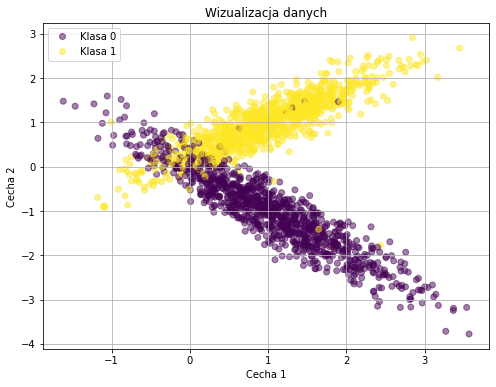

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(syn1_data['train']['x'][:,0], syn1_data['train']['x'][:,1], c=syn1_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()
ax.set_title('Wizualizacja danych');

### Dane syntetyczne 2

In [6]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generowanie
syn2_x, syn2_y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

# Podział na zbiory
syn2_train_x, syn2_test_x, syn2_train_y, syn2_test_y = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn2_data = {
    'train': {
        'x': syn2_train_x,
        'y': syn2_train_y,
    },
    'test': {
        'x': syn2_test_x,
        'y': syn2_test_y,
    }
}

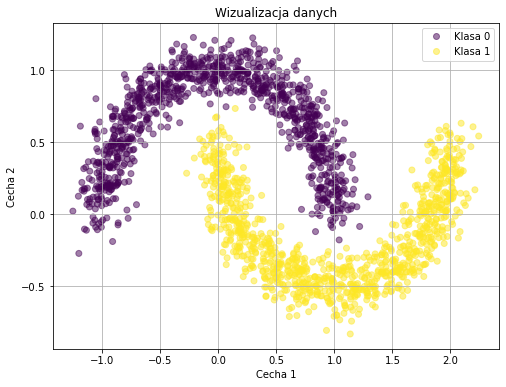

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(syn2_data['train']['x'][:,0], syn2_data['train']['x'][:,1], c=syn2_data['train']['y'], alpha=0.5)
ax.set_xlabel('Cecha 1')
ax.set_ylabel('Cecha 2')
ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
ax.grid()
ax.set_title('Wizualizacja danych');

## Implementacje maszyn SVM

### Liniowa SVM

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse
from scipy.optimize import minimize
from numpy.random import RandomState
from itertools import product
from scipy.optimize import LinearConstraint


class CustomLinearSVC(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1, max_samples=100, tol=None, max_iter=10, random_state=None, disp=False):
        self.C = C
        self.max_samples = max_samples
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.disp = disp
        
        self.rs = RandomState(random_state)
        
        self.w = None
        self.b = None

    def fit(self, X, y):
        # replace 0 labels with -1
        y = y.flatten()
        y = np.copy(y)
        y[y == 0] = -1

        # make X array dense
        if issparse(X):
            X = X.A
            
        # sample data
        X, y = self._sample_xy(X, y)

        # minimize
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, np.inf) for _ in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        constraint2 = LinearConstraint(np.ones((X.shape[0],)), 0, self.C)
        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y),
            bounds=alphas_bounds,
            constraints=(constraint1, constraint2),
            tol=self.tol,
            options={'maxiter': self.max_iter, 'disp': self.disp}
        )
        alphas = res.x.ravel()

        # calculate parameters
        self.w = self._calc_weights(alphas, y, X)
        self.b = self._calc_bias(self.w, y, X)

        return self
    
    def _sample_xy(self, X, y):
        n_samples = min(X.shape[0], self.max_samples)
        sampled_X, _, sampled_y, _ = train_test_split(
            X, y,
            train_size=n_samples,
            stratify=y,
            random_state=self.rs
        )
        return sampled_X, sampled_y

    @staticmethod
    def _loss(v, X, ys):
        alphas = v.flatten()
        n = alphas.size

        s = 0
        for i, j in product(range(n), range(n)):
            s += alphas[i]*alphas[j]*ys[i]*ys[j]*(X[i]@X[j])
        return s - np.sum(alphas)

    @staticmethod
    def _calc_weights(alphas, ys, xs):
        e = [alpha*y*x for alpha, y, x in zip(alphas, ys, xs)]
        s = np.sum(e, axis=0)
        return s.reshape(-1, 1)

    @staticmethod
    def _calc_bias(weights, ys, xs):
        weights = weights.flatten()
        e = [y-weights.dot(x) for y, x in zip(ys, xs)]
        s = np.sum(e, axis=0)
        return s / xs.shape[0]

    def decision_function(self, X):
        result = X@self.w + self.b
        return result.ravel()

    def predict(self, X):
        return self.decision_function(X) > 0

### Kernelizowana SVM

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse
from scipy.optimize import minimize
from numpy.random import RandomState
from itertools import product
from scipy.optimize import LinearConstraint


class CustomSVC(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1, kernel='linear', degree=3, coef0=0, gamma=1,
                 max_samples=100, tol=None, max_iter=10, random_state=None, disp=False):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.max_samples = max_samples
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.disp = disp
        
        self.kernel_fun = self._get_kernel_fun_by_name(kernel)
        self.rs = RandomState(random_state)
        
        self.alphas = None
        self.X = None
        self.y = None
        self.b = None

    def fit(self, X, y):
        # replaces 0 labels with -1
        y = y.flatten()
        y = np.copy(y)
        y[y == 0] = -1

        # convert to dense array
        if issparse(X):
            X = X.A
            
        # sample data
        X, y = self._sample_xy(X, y)

        # minimization
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, np.inf) for _ in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        constraint2 = LinearConstraint(np.ones((X.shape[0],)), 0, self.C)
        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y, self.kernel_fun),
            bounds=alphas_bounds,
            constraints=(constraint1, constraint2),
            tol=self.tol,
            options={'maxiter': self.max_iter, 'disp': self.disp}
        )
        alphas = res.x.ravel()

        # save results
        self.alphas = alphas
        self.X = X
        self.y = y
        self.b = self._calc_bias(alphas, y, X, self.kernel_fun)

        return self
    
    def _sample_xy(self, X, y):
        n_samples = min(X.shape[0], self.max_samples)
        sampled_X, _, sampled_y, _ = train_test_split(
            X, y,
            train_size=n_samples,
            stratify=y,
            random_state=self.rs
        )
        return sampled_X, sampled_y

    @staticmethod
    def _loss(v, X, ys, kernel_fun):
        alphas = v.flatten()
        n = alphas.size

        s = 0
        for i, j in product(range(n), range(n)):
            s += alphas[i]*alphas[j]*ys[i]*ys[j]*kernel_fun(X[i], X[j])
        return s - np.sum(alphas)

    @staticmethod
    def _calc_bias(alphas, ys, xs, kernel):
        n = xs.shape[0]
        outer_sum = 0
        for i in range(n):
            inner_sum_parts_generator = (alphas[j] * ys[j] * kernel(xs[i], xs[j]) for j in range(n))
            inner_sum = sum(inner_sum_parts_generator)
            outer_sum_part = ys[i] - inner_sum
            outer_sum += outer_sum_part
        return outer_sum / n
    
    def _get_kernel_fun_by_name(self, kernel_name):
        if kernel_name == 'linear':
            return self._kernel_linear
        elif kernel_name == 'poly':
            return self._kernel_poly
        elif kernel_name == 'rbf':
            return self._kernel_rbf
    
    def _kernel_linear(self, a, b):
        return a@b
    
    def _kernel_poly(self, a, b):
        return (a@b + self.coef0) ** self.degree
    
    def _kernel_rbf(self, a, b):
        diff = a-b
        magnitude = np.sqrt(diff@diff)
        return np.exp(-self.gamma*magnitude)

    def decision_function(self, X):
        n = self.X.shape[0]
        kernel_fun = np.vectorize(self.kernel_fun, signature='(n),(n)->()')
        sum_parts = (self.alphas[i] * self.y[i] * kernel_fun(self.X[i], X) for i in range(n))
        sum_value = sum(sum_parts)
        result = sum_value + self.b
        return result.ravel()

    def predict(self, X):
        return self.decision_function(X) > 0

## Część I

### Pierwszy zbiór

#### Nauka

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

custom_model_syn1 = make_pipeline(
    MinMaxScaler(),
    CustomLinearSVC(C=20, max_samples=100, max_iter=60, tol=1e-15, disp=False, random_state=seed)
)

start = time()
custom_model_syn1.fit(syn1_data['train']['x'], syn1_data['train']['y']);
print(f'Fit time: {time()-start:.2f}')

Fit time: 127.71


In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

scikit_model_syn1 = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='linear', C=1, random_state=seed)
)

start = time()
scikit_model_syn1.fit(syn1_data['train']['x'], syn1_data['train']['y']);
print(f'Fit time: {time()-start:.2}')

Fit time: 0.032


#### Powierzchnia decyzyjna

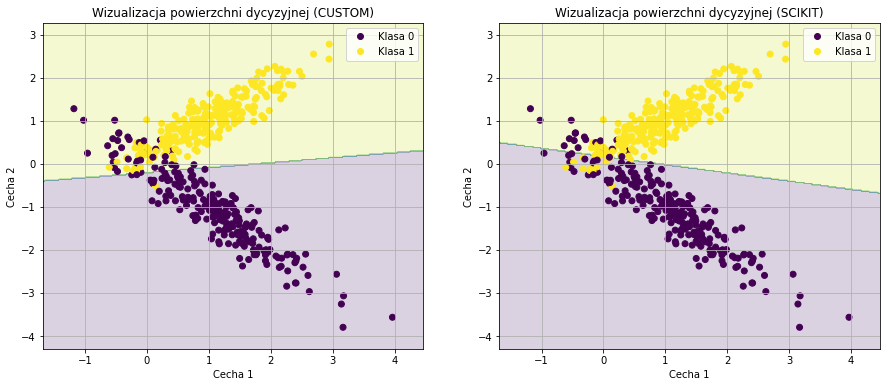

In [18]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn1_data['test']

resolution = 300
margin = 0.5
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn1, 'custom', axs[0]),
    (scikit_model_syn1, 'scikit', axs[1]),
):
    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = model.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    scatter = ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

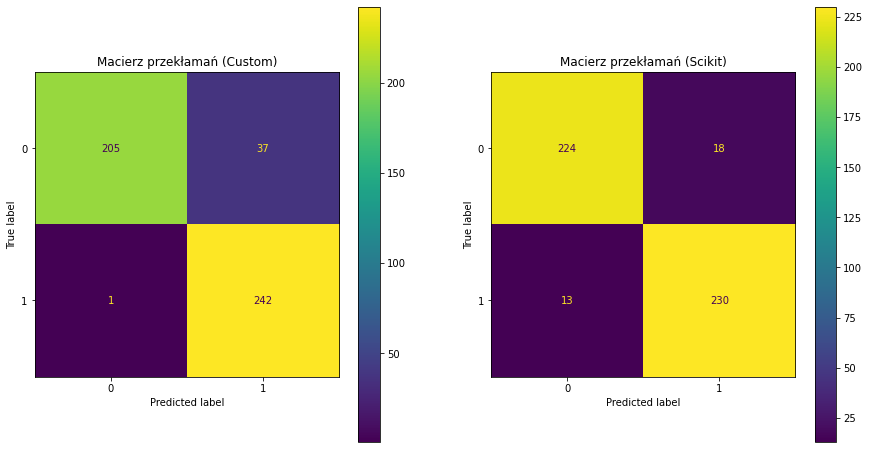

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn1, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn1, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [20]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = syn1_data['test']

sens_list = []
spec_list = []
f1_list = []

for model in [custom_model_syn1, scikit_model_syn1]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)
    f1 = f1_score(data['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1
Custom,0.995885,0.847107,0.927203
Scikit,0.946502,0.925620,0.936864


#### Krzywa ROC

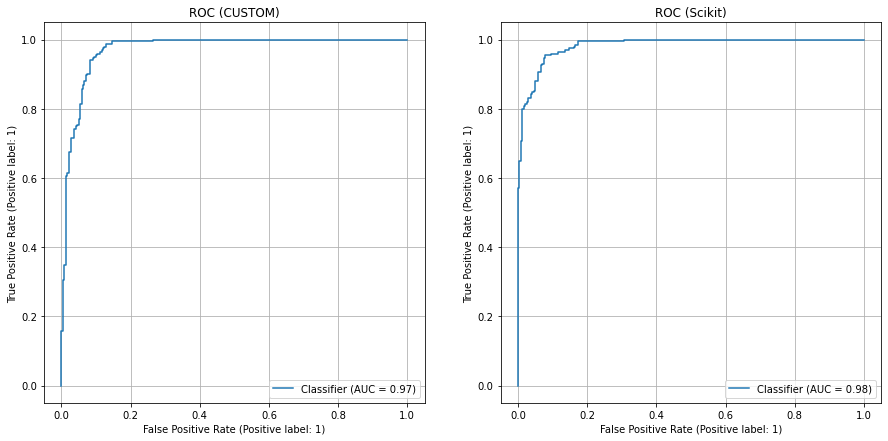

In [21]:
from sklearn.metrics import RocCurveDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn1.decision_function(data['x'])
predictions_s = scikit_model_syn1.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)')

ax_c.grid()
ax_s.grid()

#### Czasy

In [24]:
# Pomiar czasów
from sklearn.base import clone
import timeit

def time_custom_predict():
    custom_model_syn1.predict(syn1_data['test']['x'])

def time_scikit_predict():
    scikit_model_syn1.predict(syn1_data['test']['x'])

time_cp = timeit.timeit(time_custom_predict, number=1000) / 1000
time_sp = timeit.timeit(time_scikit_predict, number=1000) / 1000

time_df = pd.DataFrame({'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Przewidywanie
Custom,0.000061
Scikit,0.006933


### Drugi zbiór

#### Nauka

In [47]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from time import time

custom_model_syn2 = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    CustomLinearSVC(C=1e11, max_samples=70, max_iter=600, tol=1e-15, random_state=seed)
)

start = time()
custom_model_syn2.fit(syn2_data['train']['x'], syn2_data['train']['y'])
print(f'Fit time: {time()-start:.2f}')

Fit time: 487.83


In [31]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from time import time

scikit_model_syn2 = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=3, include_bias=False),
    SVC(kernel='linear', C=1e10, coef0=1, random_state=seed)
)

start = time()
scikit_model_syn2.fit(syn2_data['train']['x'], syn2_data['train']['y'])
print(f'Fit time: {time()-start:.2f}')

Fit time: 0.11


#### Powierzchnia decyzyjna

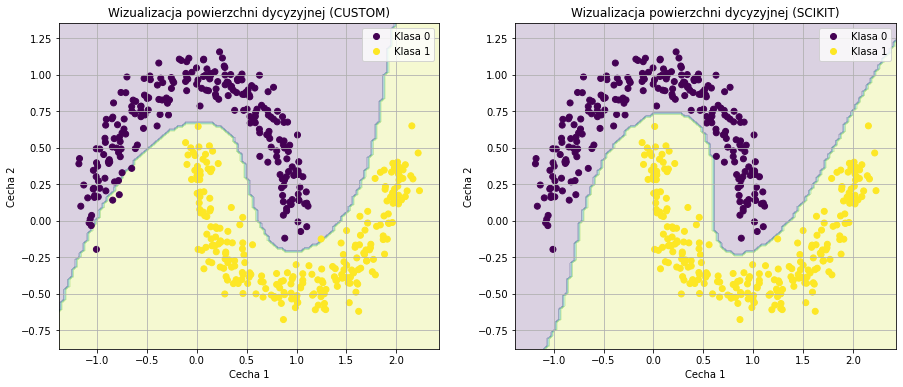

In [48]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn2_data['test']

resolution = 100
margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn2, 'custom', axs[0]),
    (scikit_model_syn2, 'scikit', axs[1]),
):
    space_syn2 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn2 = model.predict(np.dstack([*space_syn2]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn2[0], space_syn2[1], predictions_syn2, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

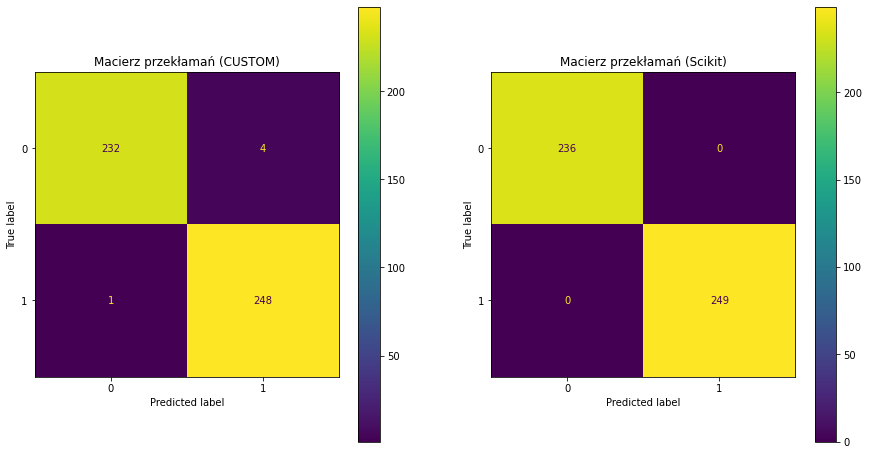

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn2_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn2, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn2, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (CUSTOM)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [50]:
from sklearn.metrics import recall_score

# Obliczanie metryk
data = syn2_data['test']

sens_list = []
spec_list = []

for model in [custom_model_syn2, scikit_model_syn2]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)

    sens_list.append(sens)
    spec_list.append(spec)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity
Custom,0.995984,0.983051
Scikit,1.000000,1.000000


#### Krzywa ROC

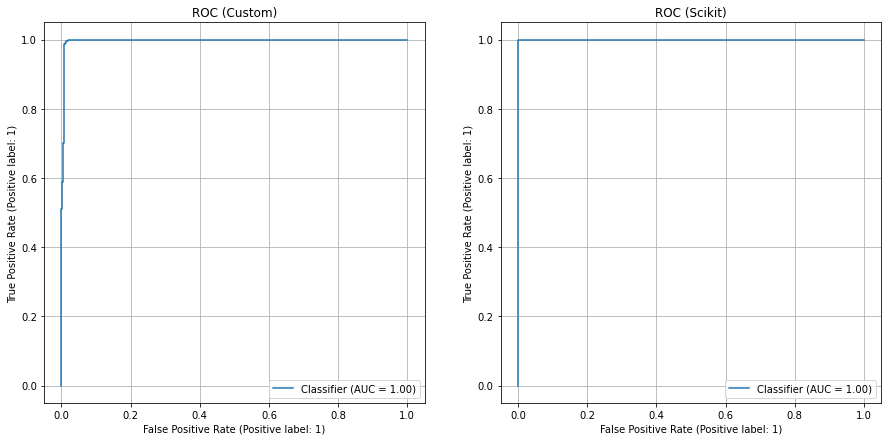

In [51]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = syn2_data['train']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn2.decision_function(data['x'])
predictions_s = scikit_model_syn2.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (Custom)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Czasy

In [54]:
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

def time_custom_predict():
    custom_model_syn2.predict(syn2_data['test']['x'])

def time_scikit_predict():
    scikit_model_syn2.predict(syn2_data['test']['x'])

time_cp = timeit.timeit(time_custom_predict, number=1000) / 1000
time_sp = timeit.timeit(time_scikit_predict, number=1000) / 1000

time_df = pd.DataFrame({'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Przewidywanie
Custom,0.000144
Scikit,0.000416


## Część II

### a) Kernel wielomianowy

#### 1. Pierwszy zbiór

#### Nauka

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

custom_model_syn1_2 = make_pipeline(
    MinMaxScaler(),
    CustomSVC(kernel='poly', max_samples=60, degree=2, coef0=1, C=1e10,
              max_iter=100, tol=1e-20, disp=False, random_state=seed)
)

start = time()
custom_model_syn1_2.fit(syn1_data['train']['x'], syn1_data['train']['y']);
print('Time:', time()-start)

Time: 62.77702045440674


In [78]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

scikit_model_syn1_2 = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='poly', degree=2, coef0=1, C=1e10, random_state=seed)
)

start = time()
scikit_model_syn1_2.fit(syn1_data['train']['x'], syn1_data['train']['y']);
print('Time:', time()-start)

Time: 22.57061743736267


#### Powierzchnia decyzyjna

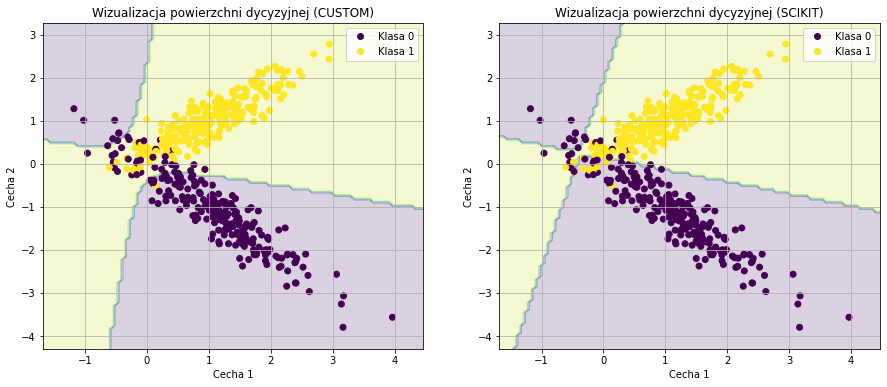

In [79]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn1_data['test']

resolution = 100
margin = 0.5
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn1_2, 'custom', axs[0]),
    (scikit_model_syn1_2, 'scikit', axs[1]),
):
    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = model.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    scatter = ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

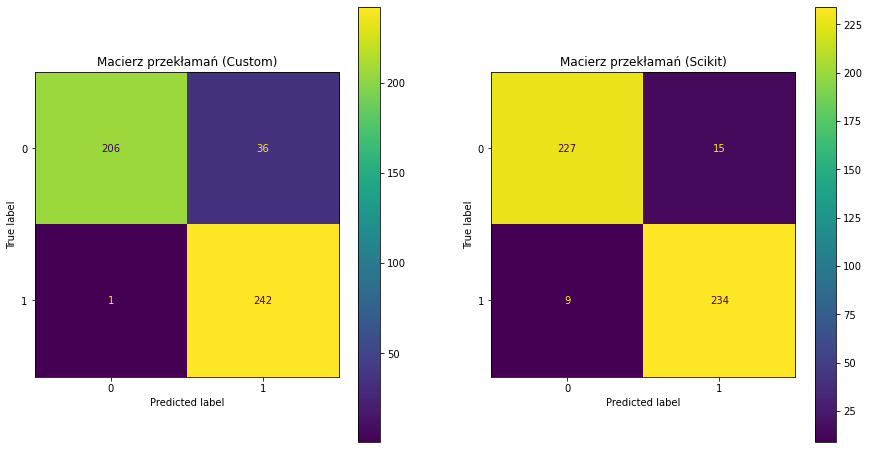

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn1_2, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn1_2, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [82]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = syn1_data['test']

sens_list = []
spec_list = []
f1_list = []

for model in [custom_model_syn1_2, scikit_model_syn1_2]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)
    f1 = f1_score(data['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1
Custom,0.995885,0.851240,0.928983
Scikit,0.962963,0.938017,0.951220


#### Krzywa ROC

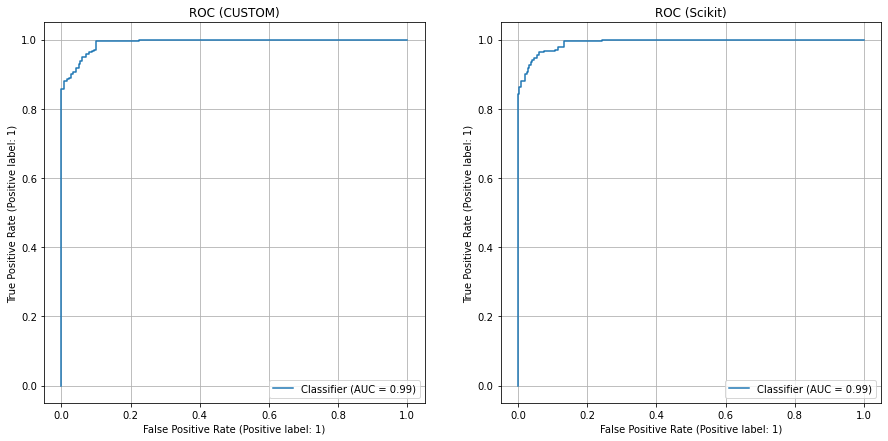

In [83]:
from sklearn.metrics import RocCurveDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn1_2.decision_function(data['x'])
predictions_s = scikit_model_syn1_2.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)')

ax_c.grid()
ax_s.grid()

#### Czasy

In [87]:
# Pomiar czasów
from sklearn.base import clone
import timeit


def time_custom_predict():
    custom_model_syn1_2.predict(syn1_data['test']['x'])

def time_scikit_predict():
    scikit_model_syn1_2.predict(syn1_data['test']['x'])


time_cp = timeit.timeit(time_custom_predict, number=100) / 100
time_sp = timeit.timeit(time_scikit_predict, number=100) / 100

time_df = pd.DataFrame({'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Przewidywanie
Custom,0.104311
Scikit,0.003138


### 2. Drugi zbiór

#### Nauka

In [111]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

custom_model_syn2_2 = make_pipeline(
    MinMaxScaler(),
    CustomSVC(kernel='poly', degree=3, coef0=1, C=1e10, max_samples=70, max_iter=400, tol=1e-20)
)

start = time()
custom_model_syn2_2.fit(syn2_data['train']['x'], syn2_data['train']['y']);
print('Time:', time()-start)

Time: 405.67907643318176


In [107]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

scikit_model_syn2_2 = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='poly', degree=3, C=1e10, coef0=1, random_state=seed)
)

start = time()
scikit_model_syn2_2.fit(syn2_data['train']['x'], syn2_data['train']['y']);
print('Time:', time()-start)

Time: 0.14011907577514648


#### Powierzchnia decyzyjna

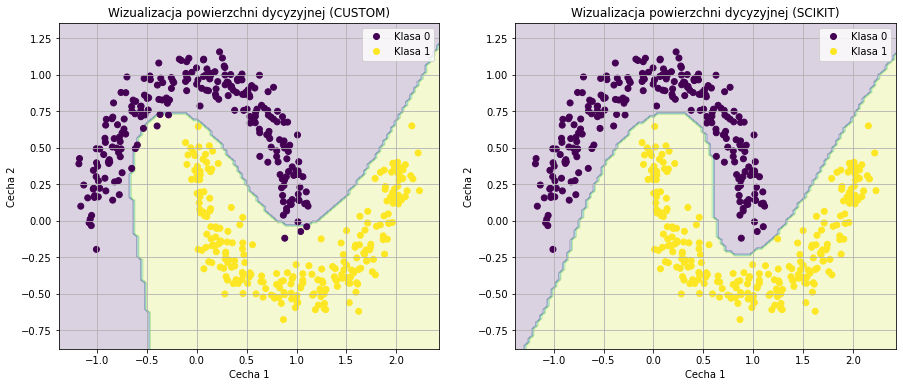

In [112]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn2_data['test']

resolution = 100
margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn2_2, 'custom', axs[0]),
    (scikit_model_syn2_2, 'scikit', axs[1]),
):
    space_syn2 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn2 = model.predict(np.dstack([*space_syn2]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn2[0], space_syn2[1], predictions_syn2, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

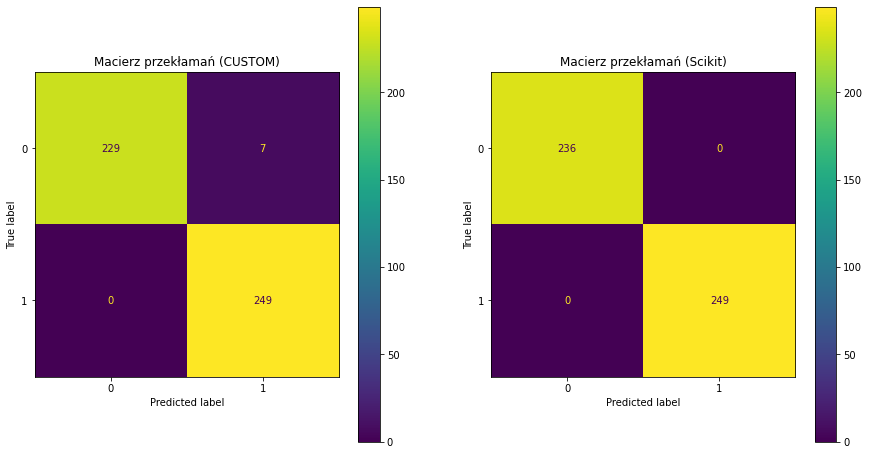

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn2_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn2_2, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn2_2, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (CUSTOM)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [115]:
from sklearn.metrics import recall_score

# Obliczanie metryk
data = syn2_data['test']

sens_list = []
spec_list = []

for model in [custom_model_syn2_2, scikit_model_syn2_2]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)

    sens_list.append(sens)
    spec_list.append(spec)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity
Custom,1.0,0.970339
Scikit,1.0,1.000000


#### Krzywa ROC

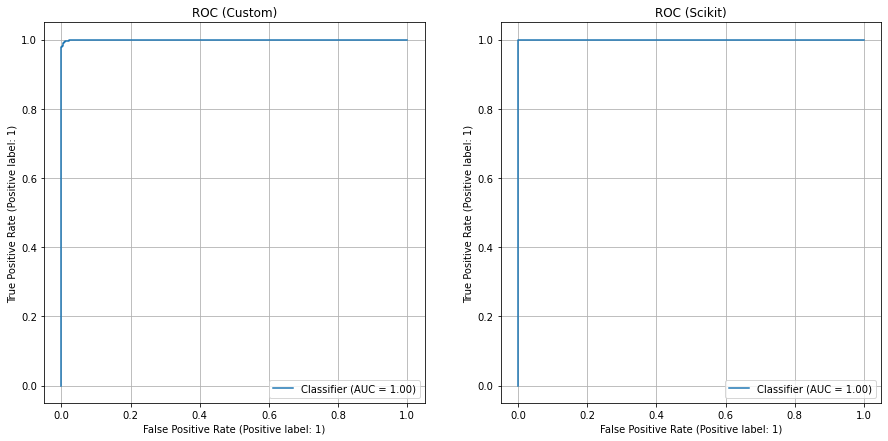

In [116]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = syn2_data['train']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn2_2.decision_function(data['x'])
predictions_s = scikit_model_syn2_2.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (Custom)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Czasy

In [117]:
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

def time_custom_predict():
    custom_model_syn2_2.predict(syn2_data['test']['x'])

def time_scikit_predict():
    scikit_model_syn2_2.predict(syn2_data['test']['x'])

time_cp = timeit.timeit(time_custom_predict, number=10) / 10
time_sp = timeit.timeit(time_scikit_predict, number=10) / 10

time_df = pd.DataFrame({'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Przewidywanie
Custom,0.126113
Scikit,0.000355


### b) Kernel RBF

#### 1. Pierwszy zbiór

#### Nauka

In [147]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

custom_model_syn1_3 = make_pipeline(
    MinMaxScaler(),
    CustomSVC(kernel='rbf', max_samples=60, gamma=50, C=1e10,
              max_iter=100, tol=1e-20, disp=False, random_state=seed)
)

start = time()
custom_model_syn1_3.fit(syn1_data['train']['x'], syn1_data['train']['y']);
print('Time:', time()-start)

C:\Users\Lukasz\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Time: 151.78626012802124


In [149]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

scikit_model_syn1_3 = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='rbf', gamma=50, C=1e10, random_state=seed)
)

start = time()
scikit_model_syn1_3.fit(syn1_data['train']['x'], syn1_data['train']['y']);
print('Time:', time()-start)

Time: 303.6842608451843


#### Powierzchnia decyzyjna

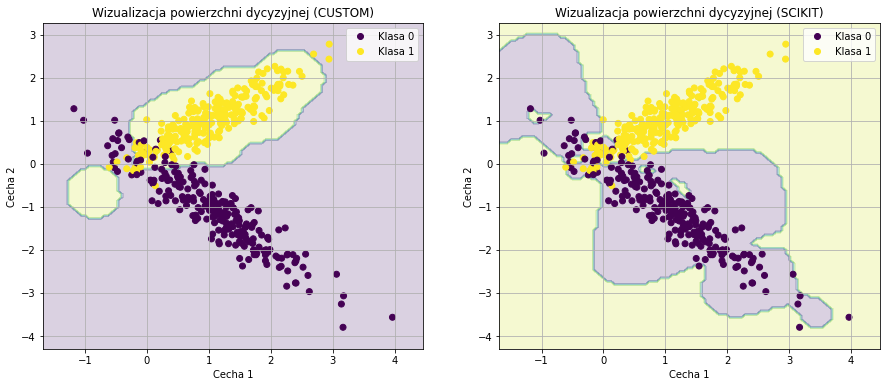

In [150]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn1_data['test']

resolution = 100
margin = 0.5
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn1_3, 'custom', axs[0]),
    (scikit_model_syn1_3, 'scikit', axs[1]),
):
    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = model.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    scatter = ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

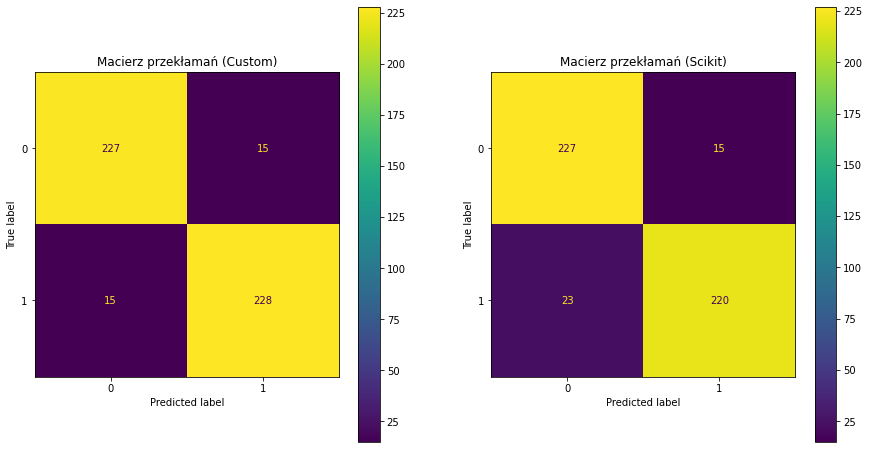

In [151]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn1_3, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn1_3, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (Custom)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [152]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = syn1_data['test']

sens_list = []
spec_list = []
f1_list = []

for model in [custom_model_syn1_3, scikit_model_syn1_3]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)
    f1 = f1_score(data['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1
Custom,0.938272,0.938017,0.938272
Scikit,0.905350,0.938017,0.920502


#### Krzywa ROC

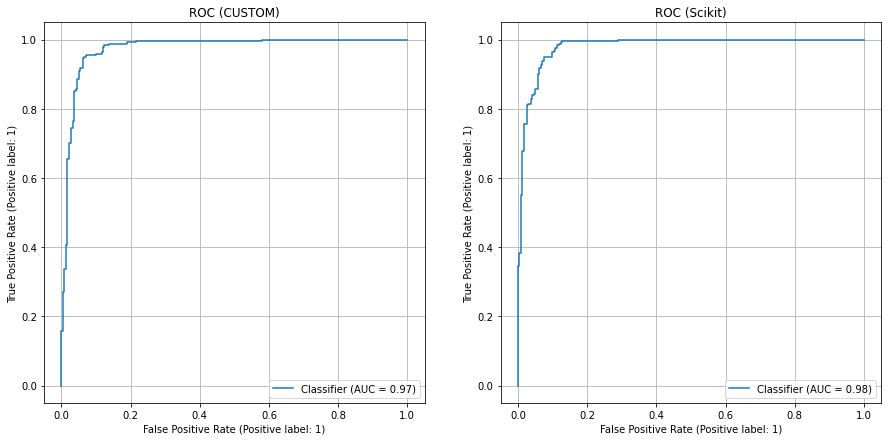

In [153]:
from sklearn.metrics import RocCurveDisplay

data = syn1_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn1_3.decision_function(data['x'])
predictions_s = scikit_model_syn1_3.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (CUSTOM)')
ax_s.set_title('ROC (Scikit)')

ax_c.grid()
ax_s.grid()

#### Czasy

In [154]:
# Pomiar czasów
from sklearn.base import clone
import timeit


def time_custom_predict():
    custom_model_syn1_3.predict(syn1_data['test']['x'])

def time_scikit_predict():
    scikit_model_syn1_3.predict(syn1_data['test']['x'])


time_cp = timeit.timeit(time_custom_predict, number=100) / 100
time_sp = timeit.timeit(time_scikit_predict, number=100) / 100

time_df = pd.DataFrame({'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Przewidywanie
Custom,0.180181
Scikit,0.009030


### 2. Drugi zbiór

#### Nauka

In [174]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

custom_model_syn2_4 = make_pipeline(
    MinMaxScaler(),
    CustomSVC(kernel='rbf', max_samples=40, gamma=20, C=1e10,
              max_iter=50, tol=1e-20, disp=False, random_state=seed)
)

start = time()
custom_model_syn2_4.fit(syn2_data['train']['x'], syn2_data['train']['y']);
print('Time:', time()-start)

C:\Users\Lukasz\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Time: 17.632043600082397


In [178]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

scikit_model_syn2_4 = make_pipeline(
    MinMaxScaler(),
    SVC(kernel='rbf', gamma=20, C=1e10, random_state=seed)
)

start = time()
scikit_model_syn2_4.fit(syn2_data['train']['x'], syn2_data['train']['y']);
print('Time:', time()-start)

Time: 0.006197214126586914


#### Powierzchnia decyzyjna

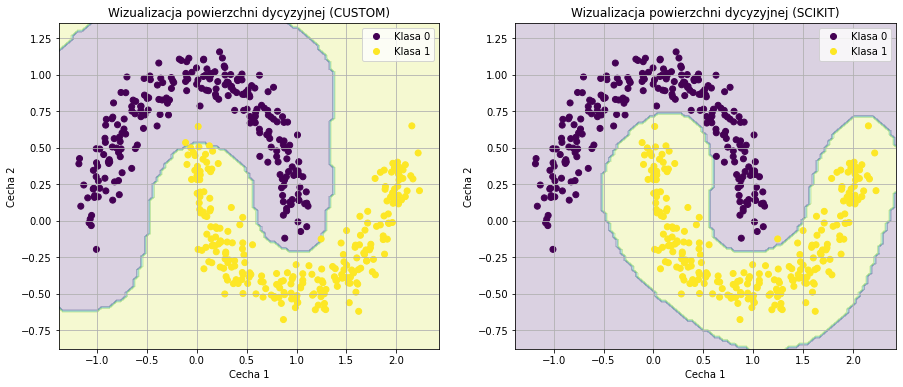

In [179]:
from sklearn.utils.extmath import cartesian

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

data = syn2_data['test']

resolution = 100
margin = 0.2
x1 = data['x'][:,0].min() - margin
x2 = data['x'][:,0].max() + margin
y1 = data['x'][:,1].min() - margin
y2 = data['x'][:,1].max() + margin

for model, name, ax in (
    (custom_model_syn2_4, 'custom', axs[0]),
    (scikit_model_syn2_4, 'scikit', axs[1]),
):
    space_syn2 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn2 = model.predict(np.dstack([*space_syn2]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn2[0], space_syn2[1], predictions_syn2, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.set_title(f'Wizualizacja powierzchni dycyzyjnej ({name.upper()})');
    ax.grid()

#### Macierz przekłamań

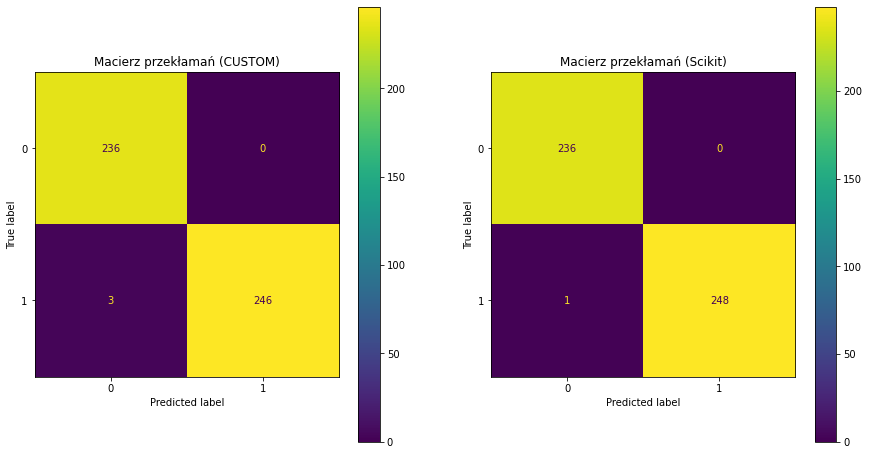

In [180]:
from sklearn.metrics import ConfusionMatrixDisplay

data = syn2_data['test']
fig, axs = plt.subplots(1, 2, figsize=(15,8))
ax_c, ax_s = axs

ConfusionMatrixDisplay.from_estimator(custom_model_syn2_4, data['x'], data['y'], ax=ax_c)
ConfusionMatrixDisplay.from_estimator(scikit_model_syn2_4, data['x'], data['y'], ax=ax_s)

ax_c.set_title('Macierz przekłamań (CUSTOM)')
ax_s.set_title('Macierz przekłamań (Scikit)');

#### Metryki

In [185]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = syn2_data['test']

sens_list = []
spec_list = []
f1_list = []

for model in [custom_model_syn2_4, scikit_model_syn2_4]:

    predictions = model.predict(data['x'])

    sens = recall_score(data['y'], predictions)
    spec = recall_score(data['y'], predictions, pos_label=0)
    f1 = f1_score(data['y'], predictions)

    sens_list.append(sens)
    spec_list.append(spec)
    f1_list.append(f1)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Custom', 'Scikit'])

,Sensitivity,Specificity,F1
Custom,0.987952,1.0,0.993939
Scikit,0.995984,1.0,0.997988


#### Krzywa ROC

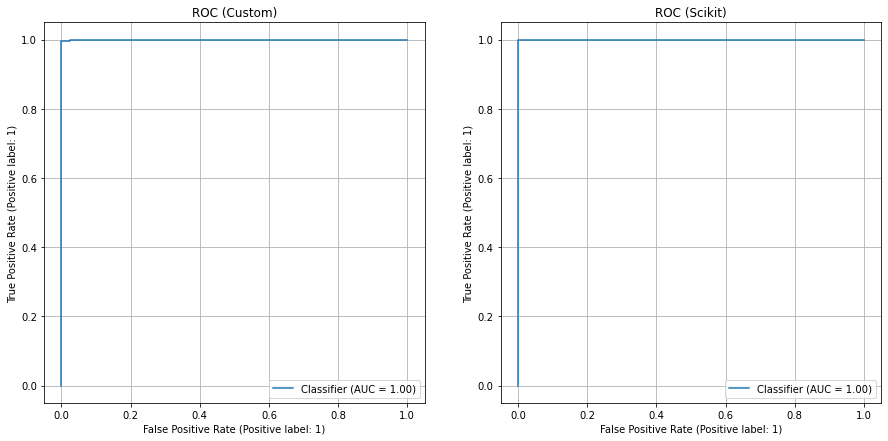

In [186]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = syn2_data['train']
fig, axs = plt.subplots(1, 2, figsize=(15,7))
ax_c, ax_s = axs

predictions_c = custom_model_syn2_4.decision_function(data['x'])
predictions_s = scikit_model_syn2_4.decision_function(data['x'])

RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax_c)
RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=ax_s)

ax_c.set_title('ROC (Custom)')
ax_s.set_title('ROC (Scikit)');

ax_c.grid()
ax_s.grid()

#### Czasy

In [187]:
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

def time_custom_predict():
    custom_model_syn2_4.predict(syn2_data['test']['x'])

def time_scikit_predict():
    scikit_model_syn2_4.predict(syn2_data['test']['x'])

time_cp = timeit.timeit(time_custom_predict, number=10) / 10
time_sp = timeit.timeit(time_scikit_predict, number=10) / 10

time_df = pd.DataFrame({'Przewidywanie': [time_cp, time_sp]}, index=['Custom', 'Scikit'])
time_df

,Przewidywanie
Custom,0.120644
Scikit,0.000958


## Część III

### Przygotowanie danych

In [20]:
# Wczytywanie
stellar_data = pd.read_csv('star_classification_SDSS17.csv', dtype={'plate': np.float64})

In [21]:
# Usunięcie zbędnych kolumn
stellar_data.drop(
    columns=['cam_col', 'MJD', 'obj_ID', 'run_ID', 'rerun_ID', 
             'field_ID', 'spec_obj_ID', 'fiber_ID'], 
    inplace=True
)

In [22]:
# Sprawdzenie brakujących wartości
stellar_data.isna().sum()

alpha       0
delta       0
u           0
g           0
r           0
i           0
z           0
class       0
redshift    0
plate       0
dtype: int64

In [23]:
# Usunięcie zbędnych rekordów
interesting_records = (stellar_data['class'] == 'GALAXY') | (stellar_data['class'] == 'STAR')
stellar_data = stellar_data[interesting_records]

In [24]:
# Wartości przewidywane
stellar_data['class'] = (stellar_data['class'] == 'STAR').to_numpy().astype(np.int32)
stellar_data_y = stellar_data['class']
stellar_data_x = stellar_data.drop(columns=['class'])

In [25]:
# Podział na zbiory
train_x, test_x, train_y, test_y = train_test_split(
    stellar_data_x, stellar_data_y,
    test_size=.2,
    random_state=seed,
    stratify=stellar_data_y,
)

# Strukturyzacja
stellar = {
    'train': {
        'x': train_x,
        'y': train_y,
    },
    'test': {
        'x': test_x,
        'y': test_y,
    }
}

### Macierz korelacji

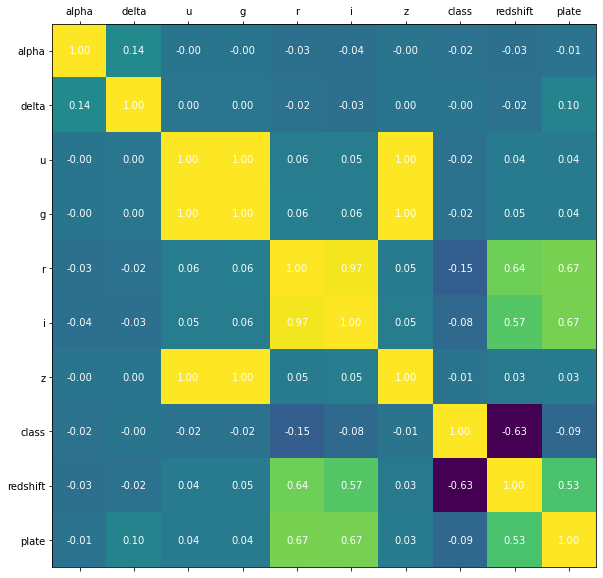

In [26]:
columns = stellar_data.columns.to_list()
corr_matrix = stellar_data[columns].corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr_matrix)
for (i, j), z in np.ndenumerate(corr_matrix):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c='w')
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
ax.set_yticks(np.arange(len(columns)))
ax.set_yticklabels(columns);

### Normalizacja wartości

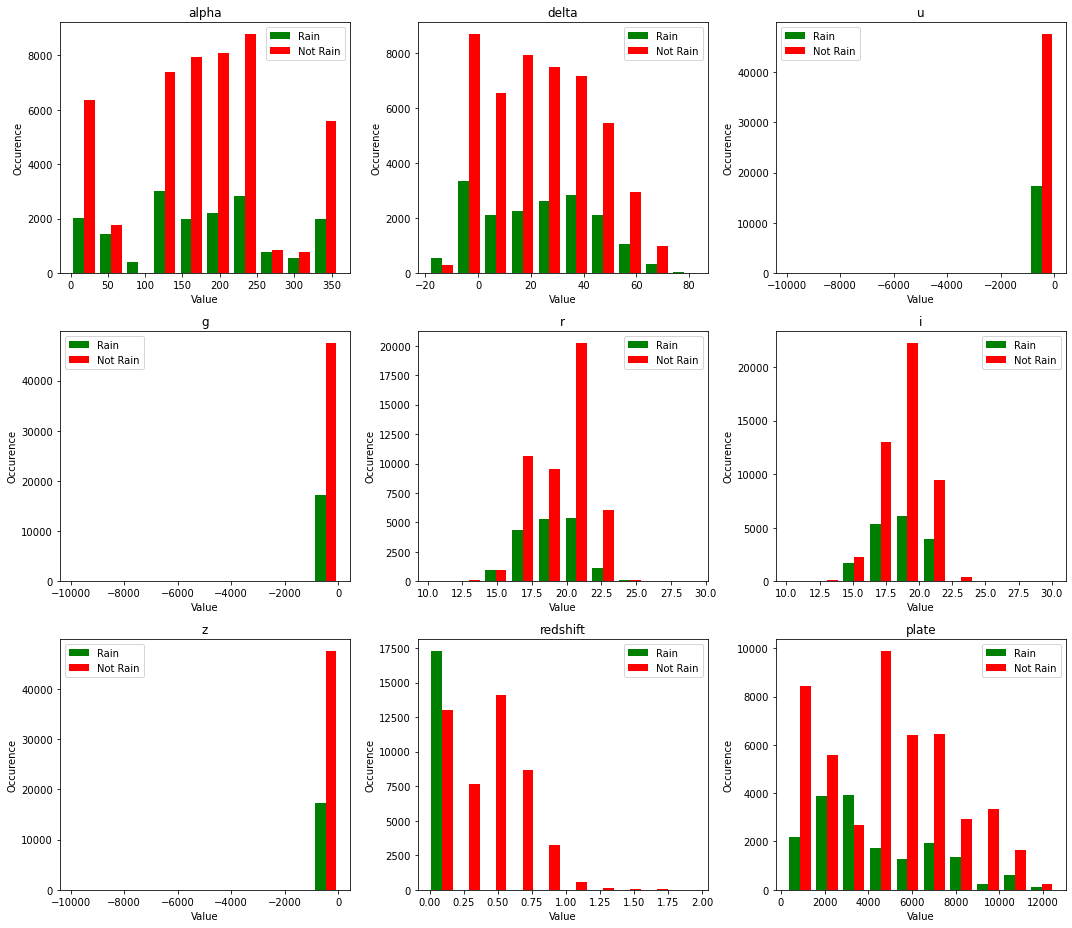

In [27]:
# Sprawdzenie rozkładów
fig, axs = plt.subplots(3, 3, figsize=(15, 13))

bins_count = 10
columns = stellar_data_x.columns.to_list()

x = stellar['train']['x']
y = stellar['train']['y']

positive_data = x[y == 1]
negative_data = x[y == 0]

for i, column in enumerate(columns):
    ax = axs[i // 3][i % 3]
    ax.hist([positive_data[column], negative_data[column]], bins=bins_count, color=['g', 'r'], label=['Rain', 'Not Rain'])

    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Occurence')
    ax.legend()

fig.tight_layout()

In [28]:
# Normalizacja / standaryzacja
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

standard_vars = ['delta', 'r', 'i']
normal_vars = ['alpha', 'u', 'g', 'z', 'redshift', 'plate']

std_transform = StandardScaler()
nor_transform = MinMaxScaler()

preprocess_pipeline = ColumnTransformer([
    ('std', std_transform, standard_vars),
    ('nor', nor_transform, normal_vars),
])

preprocess_pipeline.fit_transform(stellar['train']['x']);

### Nauka

In [29]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time

stellar_model = Pipeline([
    ('pre', preprocess_pipeline),
    ('svc', SVC(random_state=seed))
])

param_grid = {
    'svc__C': [1, 50, 1e2, 1e3, 1e4],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

search = GridSearchCV(stellar_model, param_grid, cv=3, n_jobs=-1, verbose=1)

start = time()
search.fit(stellar['train']['x'], stellar['train']['y']);
print('Time:', time()-start)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Time: 2199.269553422928


In [30]:
search.best_params_

{'svc__C': 10000.0, 'svc__kernel': 'linear'}

#### Macierz przekłamań

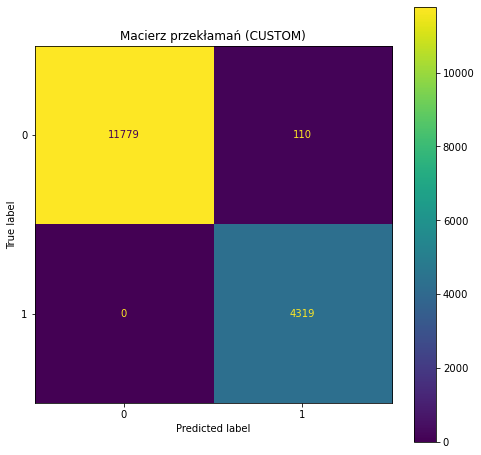

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

data = stellar['test']
fig, ax = plt.subplots(figsize=(8, 8))

ConfusionMatrixDisplay.from_estimator(search, data['x'], data['y'], ax=ax)
ax.set_title('Macierz przekłamań (CUSTOM)');

Jeśli chcemy wykorzystać klasyfikator do poszukiwania nowych galaktyk (negatywy), to nie chcemy żadnej przegapić. Oznacza to, że chcemy, aby było jak najmniej fałszywych pozytywów, nawet jeśli oznacza to większą liczbę fałszywych negatywów.

#### Metryki

In [38]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = stellar['test']

sens_list = []
spec_list = []
f1_list = []

predictions = search.predict(data['x'])

sens = recall_score(data['y'], predictions)
spec = recall_score(data['y'], predictions, pos_label=0)
f1 = f1_score(data['y'], predictions)

sens_list.append(sens)
spec_list.append(spec)
f1_list.append(f1)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': sens_list, 'Specificity': spec_list, 'F1': f1_list}, index=['Scikit'])

,Sensitivity,Specificity,F1
Scikit,1.0,0.990748,0.987426


#### Krzywa ROC

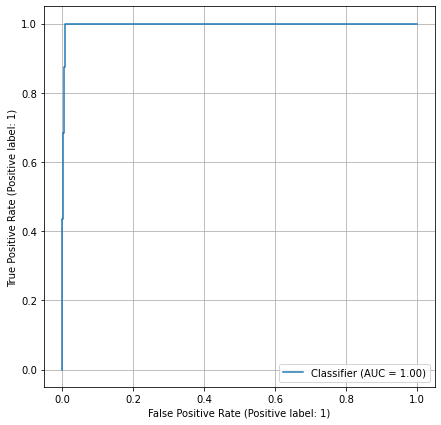

In [41]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = stellar['train']
fig, ax = plt.subplots(figsize=(7, 7))

predictions_c = search.decision_function(data['x'])
RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax)
ax_s.set_title('ROC')
ax.grid();

#### Czasy

In [43]:
from sklearn.linear_model import RidgeClassifier
from sklearn.base import clone
import timeit

def time_custom_predict():
    search.predict(stellar['test']['x'])

time = timeit.timeit(time_custom_predict, number=10) / 10
print(f'Czas przewidywania: {time}')

Czas przewidywania: 0.44199681999998575
